Analizing Dataset for ifood-data-business-analyst-test-latam-main

By: Alejandro Rojas Benítez
https://www.linkedin.com/in/arojasb3/

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

In [159]:
# We will import the data saving it as a Pandas DataFrame Object
df1 = pd.read_csv('ml_project1_data.csv')

## Variables Description

We can find the description of 25 variables, taken from the attached pdf file to the dataset 'iFood CRM Data Analyst Case.pdf':

AcceptedCmp1 : 1 if customer accepted the offer in the 1st campaign, 0 otherwise

AcceptedCmp2 : 1 if customer accepted the offer in the 2nd campaign, 0 otherwise

AcceptedCmp3 : 1 if customer accepted the offer in the 3rd campaign, 0 otherwise

AcceptedCmp4 : 1 if customer accepted the offer in the 4th campaign, 0 otherwise

AcceptedCmp5 : 1 if customer accepted the offer in the 5th campaign, 0 otherwise

Response : 1 if customer accepted the offer in the last campaign, 0 otherwise

Complain : 1 if customer complained in the last 2 years

DtCustomer : date of customer's enrollment with the company

Education : customer's level of education

Marital : customer's marital status

Kidhome : number of small children in customer's household

Teenhome : number of teenagers in customer's household

Income : customer's yearly household income

MntFishProducts : amount spent on fish products in the last 2 years

MntMeatProducts : amount spent on meat products in the last 2 years

MntFruits : amount spent on fruits in the last 2 years

MntSweetProducts : amount spent on sweet products in the last 2 years

MntWines : amount spent on wines in the last 2 years

MntGoldProds : amount spent on gold products in the last 2 years

NumDealsPurchases : number of purchases made with discount

NumCatalogPurchases : number of purchases made usuing catalogue

NumStorePurchases : number of purchases made directly in stores

NumWebPurchases : number of purchaes made through company's web site

NumWebVisitsMonth : number of visits to company's web site in the last month

Recency : number of days since last purchase

In [160]:
# First, we want to be sure the variables in the .csv are the same one mentioned in the pdf file
df1.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [161]:
len(df1.columns)

29

We can see there are 4 variables which are not described in the pdf: ID, Year_Birth, Z_revenue, Z_CostContract.

The first two make complete sense so there is no description needed, lets find out what both Z variables hide in case they are important or not

In [162]:
# Lets create some variables for fast access to important variables
campaings = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'
       ]
undocummented = ['Z_CostContact', 'Z_Revenue']

In [163]:
df1[undocummented].describe()

,Z_CostContact,Z_Revenue
count,2240.0,2240.0
mean,3.0,11.0
std,0.0,0.0
min,3.0,11.0
25%,3.0,11.0
50%,3.0,11.0
75%,3.0,11.0
max,3.0,11.0


For sure these two variables have nothing important to tell, lets start by getting rid of them

In [164]:
df1 = df1.drop(columns=undocummented);

Now lets swap some of those date/year variables into some new ones, more numerical:

Age : The age of the customers. 2021 - Year_Birth

enrollment_time : days of enrollment of the customers. Assuming from 12/31/2020 - Dt_Customer

We find out that new variables in days make sense given the fact that Recency is also on days.

In [165]:
def find_days(target, current, date_format = "%Y-%m-%d"):
    """from solution of 
    https://stackoverflow.com/questions/151199/how-to-calculate-number-of-days-between-two-given-dates"""
    a = datetime.strptime(current, date_format)
    b = datetime.strptime(target, date_format)
    delta = b - a
    return delta.days

df1['age'] = 2021 - df1['Year_Birth']
df1['enrollment_time'] = df1.apply(lambda row: find_days('2020-12-31', row['Dt_Customer']), axis=1)


In [166]:
# Now lets find out if our dataset has any NaNs
df1.columns[df1.isna().any()].tolist()

['Income']

Well, if we have NaNs on Income, one may think two possible cases: 

- They could mean those customers have no income.
- The information is missing. 

Let's find out if there are customers with an income value of zero.

In [167]:
df1['Income'].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

First, Lets just start analyzing the other columns, at the end we will see if removing this 24 customers will have impact on the dataset. We want to find and remove any outliers in our data, as an initial approach we will remove them from the dataset.

In [168]:
numerical_cols = [ 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                 'age', 'enrollment_time']

categorical_cols = ['Education', 'Marital_Status', 'Complain']

In [169]:
def plot_histograms(df, horizontal, vertical, columns, figsize=(16,8)):
    fig, axes = plt.subplots(horizontal, vertical, figsize=figsize)

    fig.tight_layout()
    for i, var in enumerate(columns):
        lm = sns.histplot( df[var], ax=list(axes.flat)[i]);

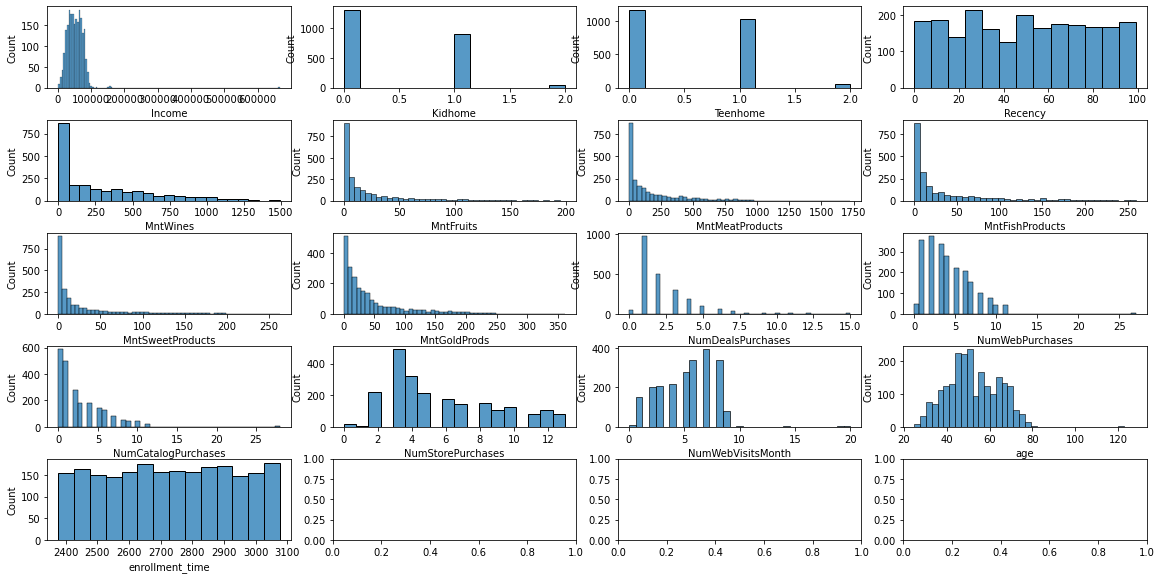

In [170]:
plot_histograms(df1, 5, 4, numerical_cols)

We can clearly see outliers on the following variables:
- Income
- NumWebPurchases
- NumCatalogPurchases
- NumWebVisitsMonth
- age
- MntMeatProducts

In [171]:
outliers = ['Income', 'NumWebPurchases', 'NumCatalogPurchases', 'NumWebVisitsMonth', 'age', 'MntMeatProducts']

In [172]:
for o in outliers:
    print(df1[o].nlargest(10))

2233    666666.0
617     162397.0
687     160803.0
1300    157733.0
164     157243.0
1653    157146.0
2132    156924.0
655     153924.0
1898    113734.0
646     105471.0
Name: Income, dtype: float64
27      27
1898    27
1975    25
1806    23
18      11
67      11
131     11
175     11
202     11
209     11
Name: NumWebPurchases, dtype: int64
21      28
687     28
1653    28
164     22
104     11
288     11
586     11
591     11
627     11
636     11
Name: NumCatalogPurchases, dtype: int64
9       20
774     20
1245    20
1042    19
1846    19
1328    17
981     14
1524    14
2214    13
47      10
Name: NumWebVisitsMonth, dtype: int64
239     128
339     122
192     121
1950     81
424      80
39       78
358      78
415      78
894      78
1150     78
Name: age, dtype: int64
21      1725
1653    1725
687     1622
2228    1607
164     1582
1358     984
1808     981
456      974
2109     968
1031     961
Name: MntMeatProducts, dtype: int64


Just plotting the 10 largest values on all 5 columns we can find that the following values start to be "out of range" of the remaining ones:
- Income -> 8
- NumWebPurchases -> 4
- NumCatalogPurchases -> 4
- NumWebVisitsMonth -> 9
- age -> 3
- MntMeatProducts -> 1

In [179]:
rem_outliers = zip(outliers, [8, 4, 4, 9, 3, 5])
indexes = set()

for o, i in rem_outliers:
    indexes.update(list(df1[o].nlargest(10).index[0:i]))
len(indexes)

26

In [180]:
list(rem_outliers)

[]

In [181]:
df2 = df1.drop(index=pd.Index(indexes))

Now that we removed some outliers, lets find out how our histograms are

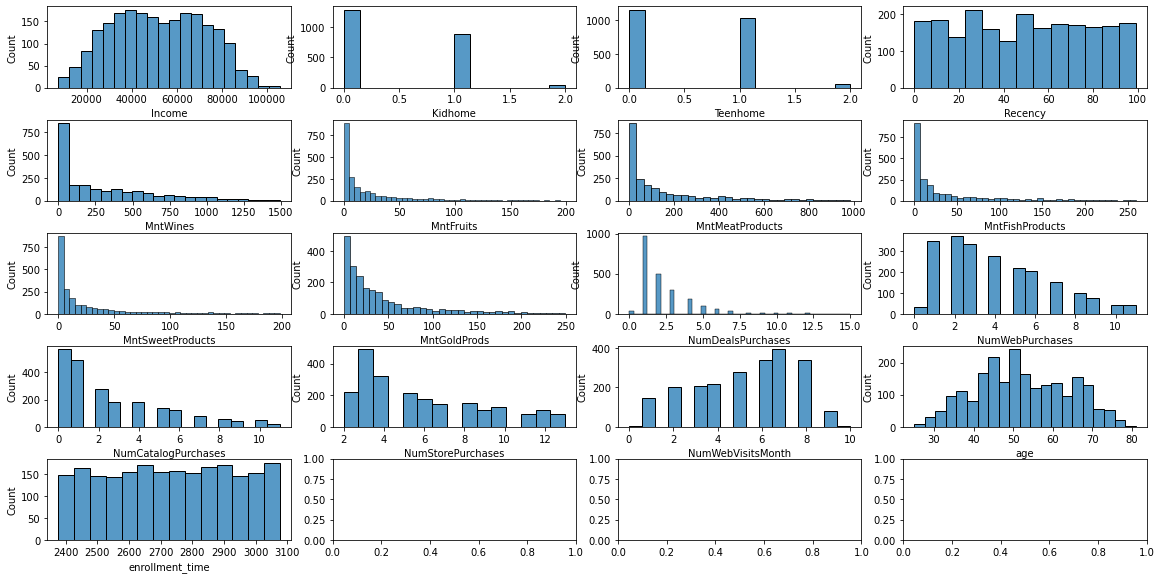

In [182]:
plot_histograms(df2, 5, 4, numerical_cols)

But no, we are not ready, lets look for outliers in our categorical variables

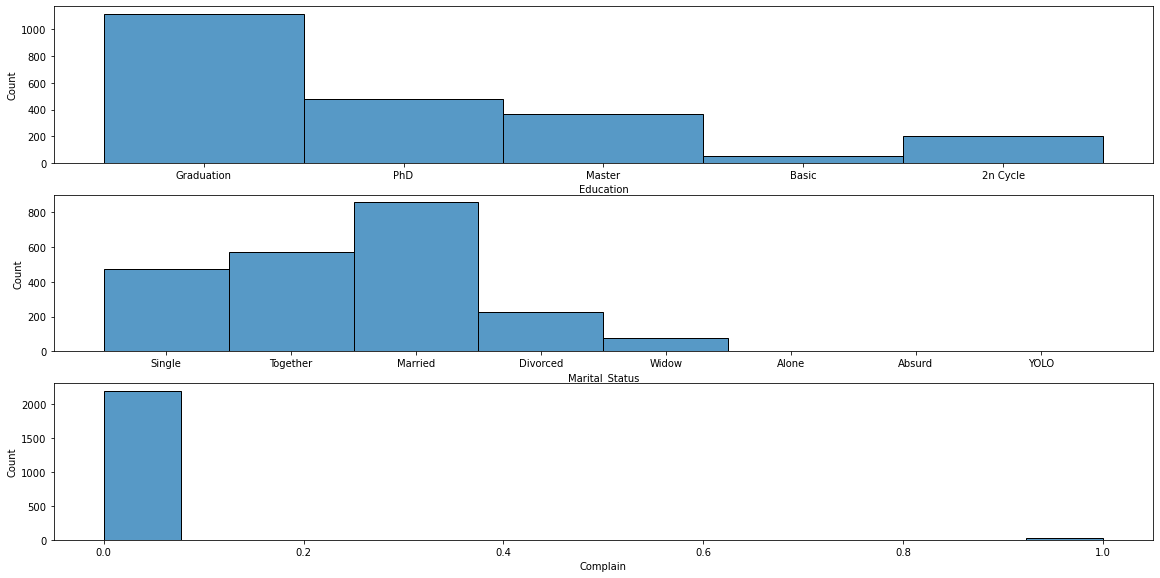

In [187]:
plot_histograms(df2, 3, 1, categorical_cols)

In [189]:
for cat in categorical_cols:
    print(df2[cat].value_counts())

Graduation    1116
PhD            476
Master         368
2n Cycle       200
Basic           54
Name: Education, dtype: int64
Married     857
Together    572
Single      473
Divorced    228
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
0    2194
1      20
Name: Complain, dtype: int64


- Education : everything seems fine
- Marital_Status : Definetly Alone, Absurd and YOLO seem to be noise in the dataset
- Complain : this variable may not have a lot of importance, anyway lets keep if for the moment

In [195]:
for cat in ['Alone', 'Absurd', 'YOLO']: 
    df2.drop(df2[df2['Marital_Status'] == cat].index, inplace = True)

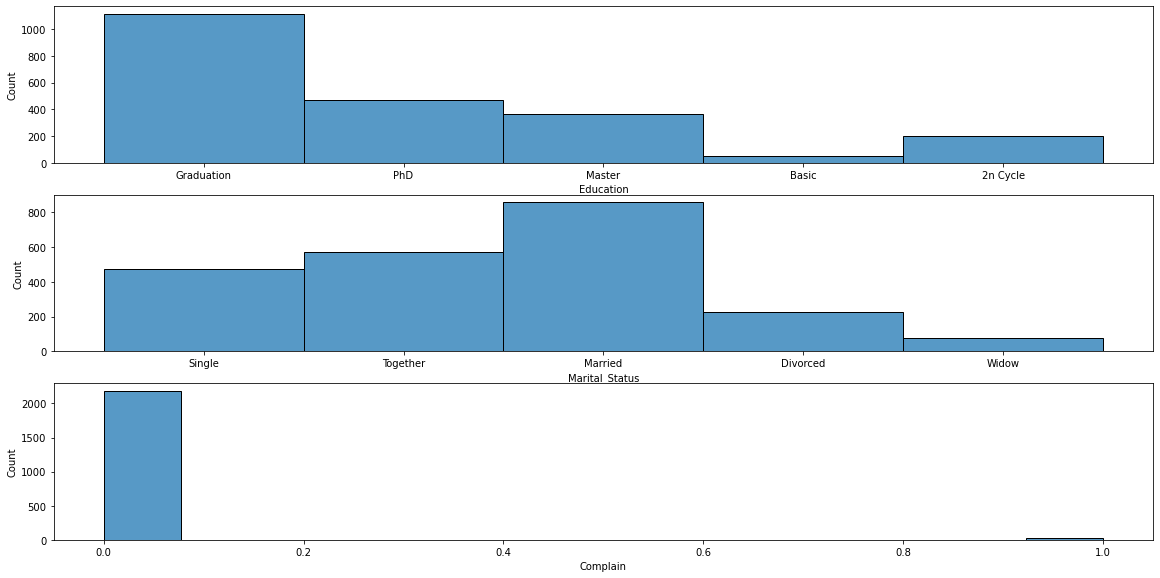

In [197]:
plot_histograms(df2, 3, 1, categorical_cols)

### Nope
Now that we found 5 columns with possible outliers, we will proceed to remove them using the following process:
- Find the corresponding value for the percentil 99.5
- Remove all rows that contain values above it

In [108]:
"""indexes = set()

for o in outliers:
    q = df1[o].quantile(0.995)
    indexes.update(list(df1[df1[o] >= q].index))
len(indexes)""";

With our data without some outliers, We will now split our dataset into the ones that had a positive and a negative answer regarding the last campaign

In [198]:
dfpositive = df2[df2['Response'] == 1]
dfnegative = df2[df2['Response'] == 0]

Initially we will just plot histograms of all the numerical variables 

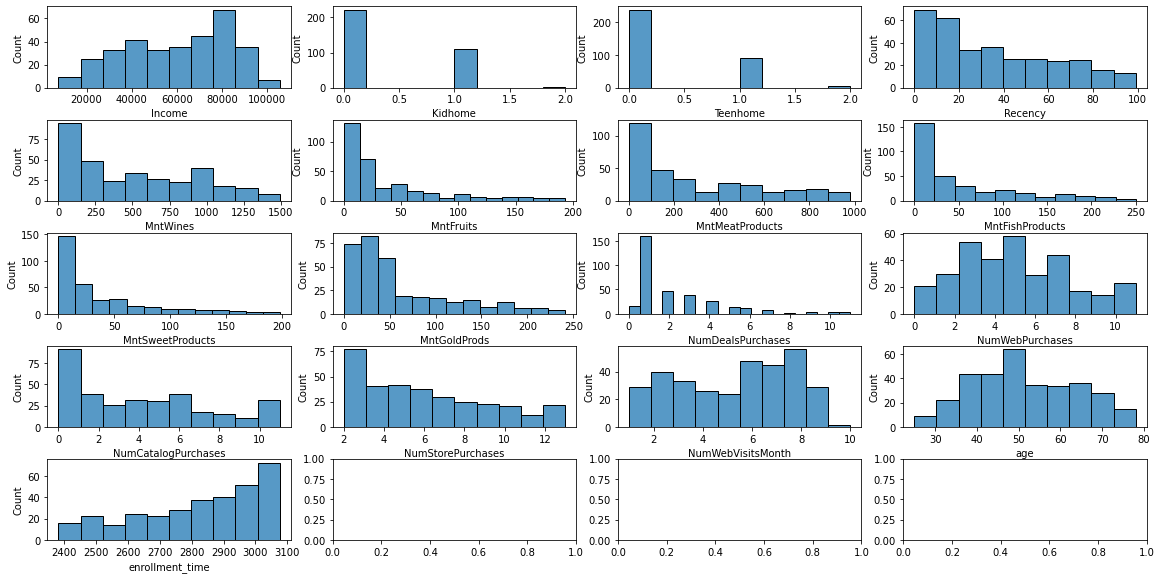

In [199]:
fig, axes = plt.subplots(5, 4, figsize=(16,8))

fig.tight_layout()
for i, var in enumerate(numerical_cols):
    lm = sns.histplot( dfpositive[var], ax=list(axes.flat)[i]);
    #lm.set_title(var)

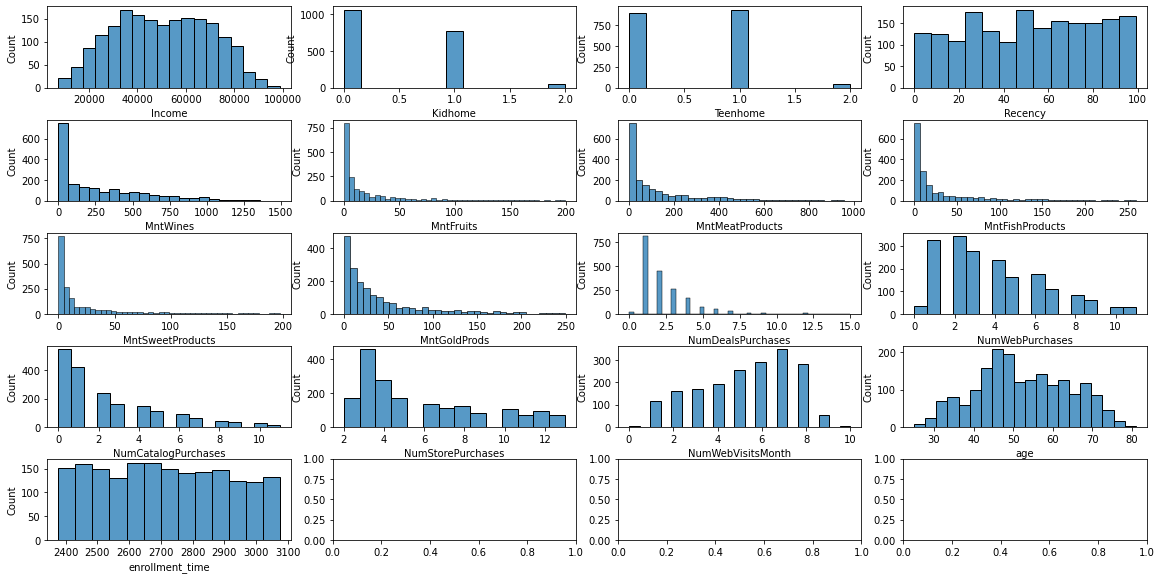

In [201]:
fig, axes = plt.subplots(5, 4, figsize=(16,8))
fig.tight_layout()
for i, var in enumerate(numerical_cols):
    lm = sns.histplot( dfnegative[var], ax=list(axes.flat)[i]);

So lets start looking at some of those variables:

- Income : We can see that most of the customers that accepted last campaign earn around 70k to 80k MU, for the ones that didn't some clear outliers are affecting our visualization.
- Kidhome : Both histograms are pretty alike, this may be not be important.
- Teenhome : Most of the customers that accepted had 0 no teens.
- Resency : Customers with lower recency preferred the campaign.
- Amount spent on products: Customers that spend money on gold, wine and meat seemed to be more interested in the campaign
- Number of purchases with discounts : Both histograms seem alike.
- Number of web purchases: Customers with 3 to 7 purchases.
- Number of catalog purchases: Cannot conclude right now.
- Number of store purchases: Customers with 2 store purchases are heavily influenced by the campaign.
- Number of web visits: Cannot conclude right now.
- Age: Around 35 and 50 years old.
- enrollment time: customers with high enrollment time, more than 2800 days.

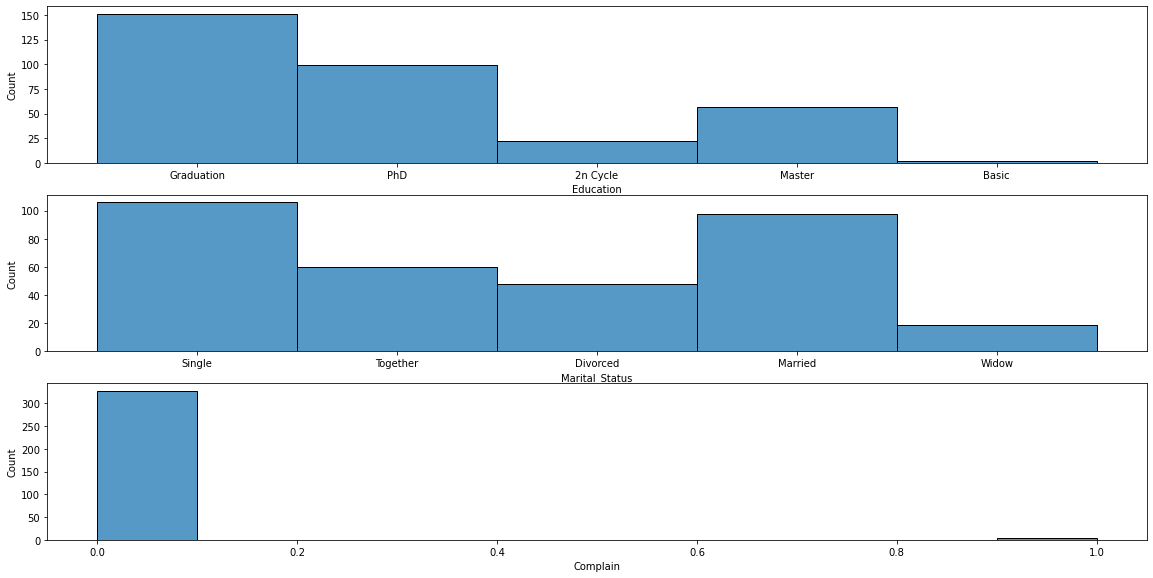

In [202]:
fig, axes = plt.subplots(3, 1, figsize=(16,8))
fig.tight_layout()
for i, var in enumerate(categorical_cols):
    sns.histplot( dfpositive[var], ax=list(axes.flat)[i]);

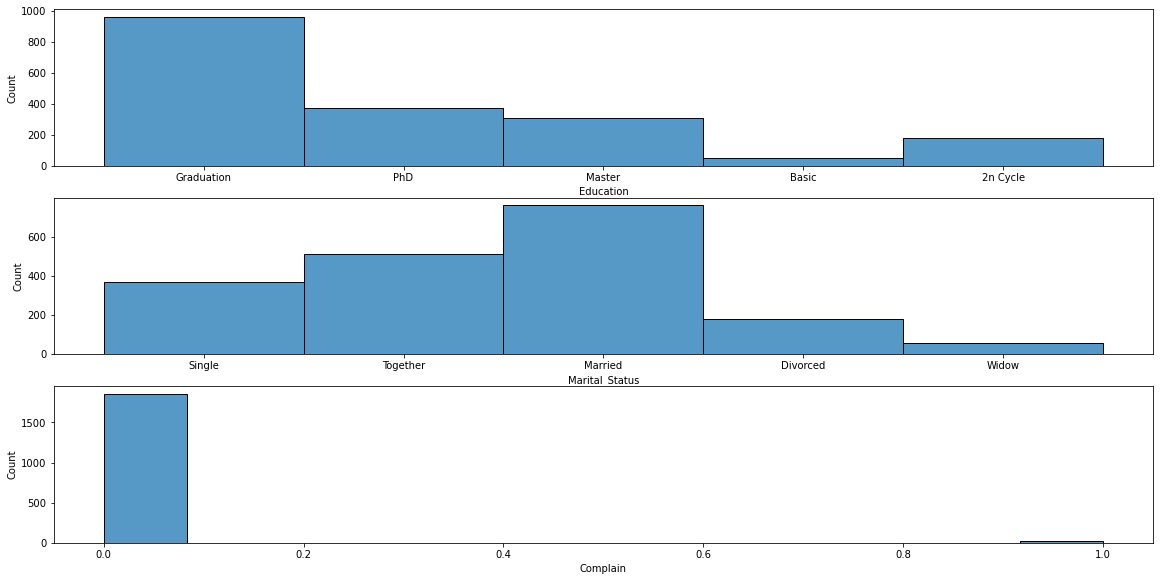

In [203]:
fig, axes = plt.subplots(3, 1, figsize=(16,8))
fig.tight_layout()
for i, var in enumerate(categorical_cols):
    sns.histplot( dfnegative[var], ax=list(axes.flat)[i]);

Regarding the categorical variables we find that:
- Education: Cannot conclude.
- Marital Status : Single customers prefer the campaign.
- Complain : Cannot conlude.

In [50]:
for campaign in campaings:
    #campaign_proportions.append(df1[campaign].value_counts())
    print(df1[campaign].value_counts())

0    2096
1     144
Name: AcceptedCmp1, dtype: int64
0    2210
1      30
Name: AcceptedCmp2, dtype: int64
0    2077
1     163
Name: AcceptedCmp3, dtype: int64
0    2073
1     167
Name: AcceptedCmp4, dtype: int64
0    2077
1     163
Name: AcceptedCmp5, dtype: int64
0    1906
1     334
Name: Response, dtype: int64


As an initial approach, lets just ignore this customers, lets find out which of them accepted any of the 6 marketing campaigns done by the company

In [32]:
df1[df1.isnull().any(axis=1)][campaings]

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
10,0,0,0,0,0,0
27,0,0,0,0,0,0
43,0,0,0,0,0,0
48,0,0,0,0,0,0
58,0,0,0,0,0,0
71,0,0,0,0,0,0
90,0,0,0,0,0,0
91,0,0,0,0,0,0
92,0,0,0,0,0,0
128,0,0,0,0,0,0


Well, only 4 customer which their Income is unknown have had a positive response on any of the 6 marketing campaings, for the moment lets just ignore them and work with the remaining rows.

In [35]:
df2 = df1.dropna()
df2.columns[df2.isna().any()].tolist()

[]